# Cluster analysis of seasonal and diurnal precipitation

## General info about K means algorithm

- input: K (nr of clusters) and data in form of 2D array)
- calculate Euclidean distance to centroids of data  
- updating centroid by calculating means of all data points which are assigned to one specific centroid's cluster

## Notes 

- GPM data: seasonal= 'GPM_IMERG_cluster_input_seasonal.nc4' , diurnal: 'GPM_IMERG_cluster_input_diurnal.nc4'
- best nr of classes for seasonal seems to be 8 
- two distinct classes when seasonality is separated ! see figures 
- always 2D input maxtrix: n x features (monthly contribution to annual precip, hourly contribution to daily precip)
- cluster analysis meaningful? Are there real clusters or just continuous differences? Maybe PCA is more suitable.. 
- plot PCA1 and PCA2 for grid (how much can a certain occurrence of seasonality explain the variance in the data? ), here there could be two modes in different combinations and intensities 
- one output is are the features for each component (seasonal curve for PCA1, seasonal curve for PCA2.....etc) 
- another output are the eigenvalues for each grid cell (data point) for each component: the larger the eigenvalue for that component, the more that component explains the data point or: how strong a number shows how dominant a the seasonality feature in a specific region is 
- include only for daily values from 0.1 mm/hr in order to derive the diurnal vectors 

## Comparison PCA and cluster analysis 

- show the same results, inversed seasonality for Karakoram and northwest out of TP (rather sharp border along the western mountain ranges)
- PCA 2 shows dipole pattern within TP, PCA1 outside 

In [19]:
from sklearn import cluster
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans


import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import *
import mpl_toolkits
import Basemap
import matplotlib.colors as colors

import scipy
from scipy import ndimage
from scipy.stats import skew
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

from numpy import genfromtxt

import pandas as pd 


ModuleNotFoundError: No module named 'Basemap'

In [13]:
# read in dataset on which the cluster analysis will be performed 
def read_in_netcdf(file):
    dataset = Dataset(file)    
    precip= np.array(dataset["precipitationCal"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return precip, lon, lat


In [14]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_seasonal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [15]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (12,351*181))
data= data.transpose()
np.shape(data)

(63531, 12)

In [21]:
X = data # input matrix shape (n_samples, n_features)
k = 7
kmeans = KMeans(n_clusters= k, random_state=0).fit(X)

# attributes
centers = kmeans.cluster_centers_ # n_clusters x n_features
labels = kmeans.labels_ # contains the actual classes 
cluster_grid= np.reshape(kmeans.labels_, ((351,181)))


np.shape(kmeans.cluster_centers_)
#np.shape(kmeans.labels_)

(7, 12)

## Plots

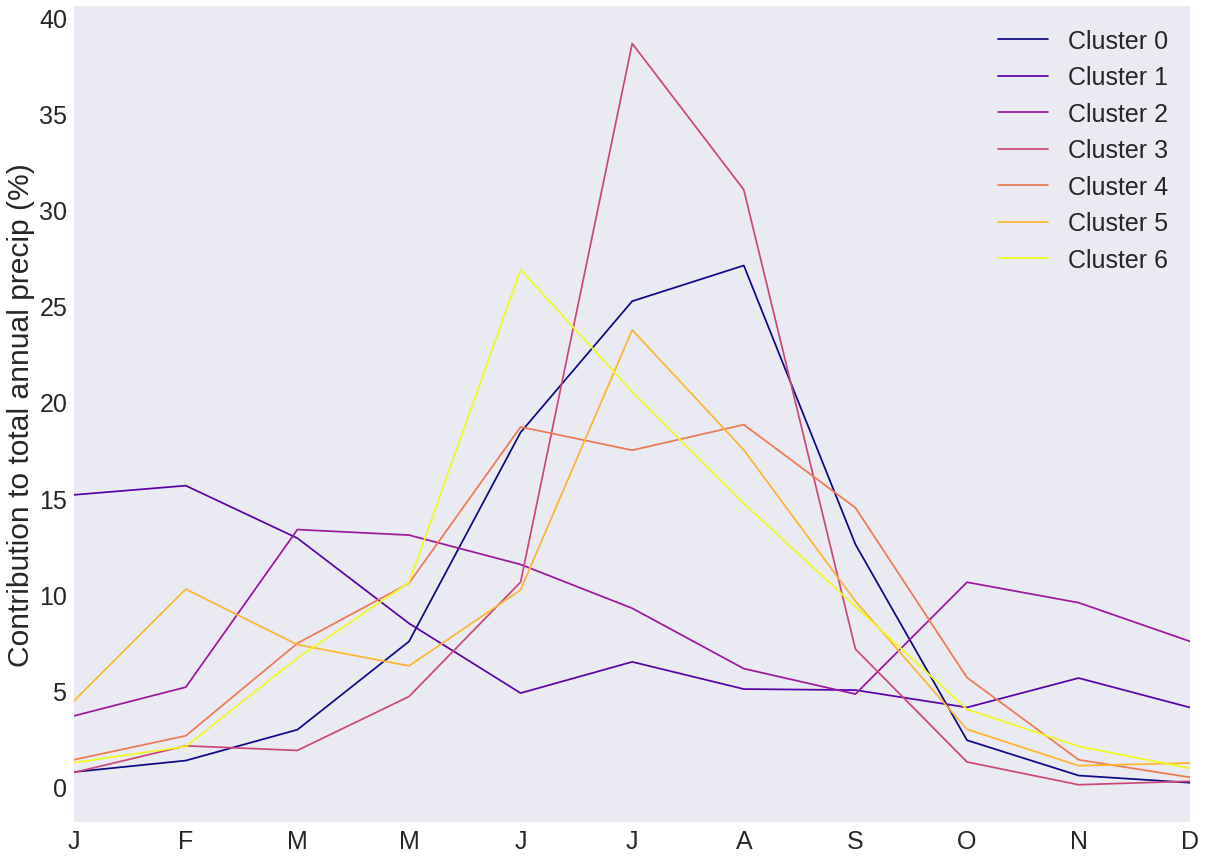

In [22]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 15))
plt.ylabel('Contribution to total annual precip (%)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.grid()
plt.xlim(1,11)


n = 7
colors = plt.cm.plasma(np.linspace(0,1,n))

for i in range(n):
    plt.plot(kmeans.cluster_centers_[i], label = 'Cluster '+ str(i) , color=colors[i])

         
         
plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})


plt.savefig('/media/juli/Elements/comparison/gpm_seasonal_cluster7.pdf')

In [77]:
# fast plot
#plt.imshow(cluster_grid)

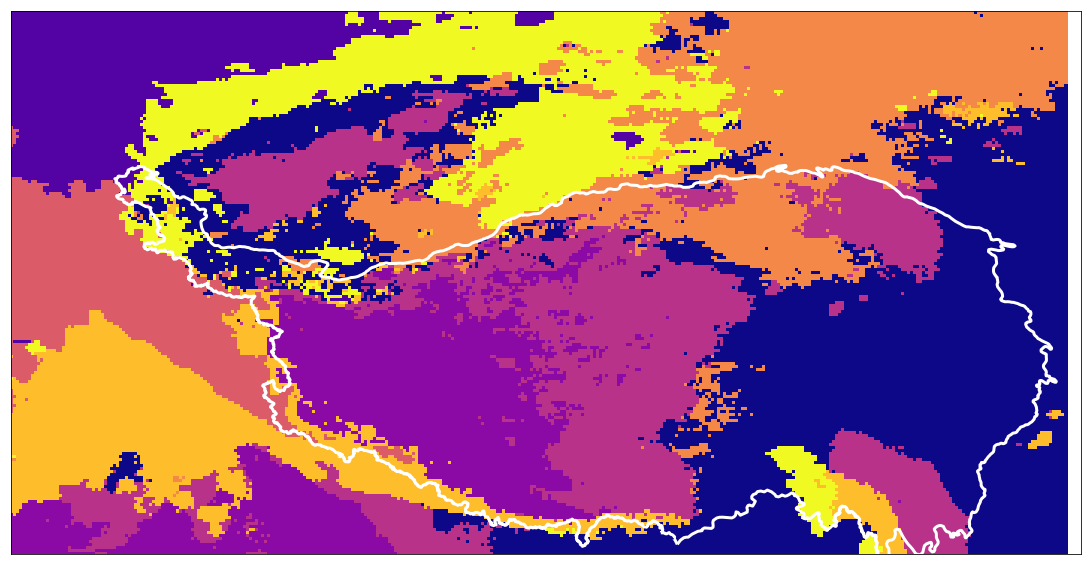

In [20]:
plt.figure(figsize=(20, 10))


cmap = plt.cm.get_cmap('plasma')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, cluster_grid.T, cmap = cmap) 


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='white', linewidth=3.0)

plt.savefig('/media/juli/Elements/comparison/cluster_seasonal_grid7_new.png')

- cluster analysis of seasonality indicate that pixels are more similar along west-east axis compared to north- south axis (different to Yao et al framework)
- two clusters are found which have opposite curve (with peaks in spring in autumn and summer depression), but these are outside of the plateau (from westerly direction)  

## check 

In [141]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_20170628_contr_to_day.nc4'
check, lon, lat = read_in_netcdf(file)


## Cluster analysis diurnal 

In [92]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/gpm_imerg_cluster_input_diurnal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [93]:
print(np.shape(precip_avg))


(8775, 181)


In [94]:
# calculate hourly instead of 30 min 
precip_avg= np.zeros((351,181))
i=0 
for idx, row in enumerate(precip[:,:]):
    if (i % 2) == 0:
        a = np.nanmean([row, precip[:,:][idx]], axis = 0)
        #print(idx, np.shape(a))
        precip_avg= np.concatenate((precip_avg, a),axis =0)
    i+=1


In [95]:
new = np.reshape(precip_avg,(25,351,181))
precip = new[1::,:,:]
np.shape(precip)

(24, 351, 181)

In [96]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (24,351*181))
data= data.transpose()

In [115]:
X = data # input matrix shape (n_samples, n_features)
k = 5
kmeans = KMeans(n_clusters= k, random_state=0).fit(X)

# attributes
centers = kmeans.cluster_centers_ # n_clusters x n_features
labels = kmeans.labels_ # contains the actual classes 
cluster_grid= np.reshape(kmeans.labels_, ((351,181)))


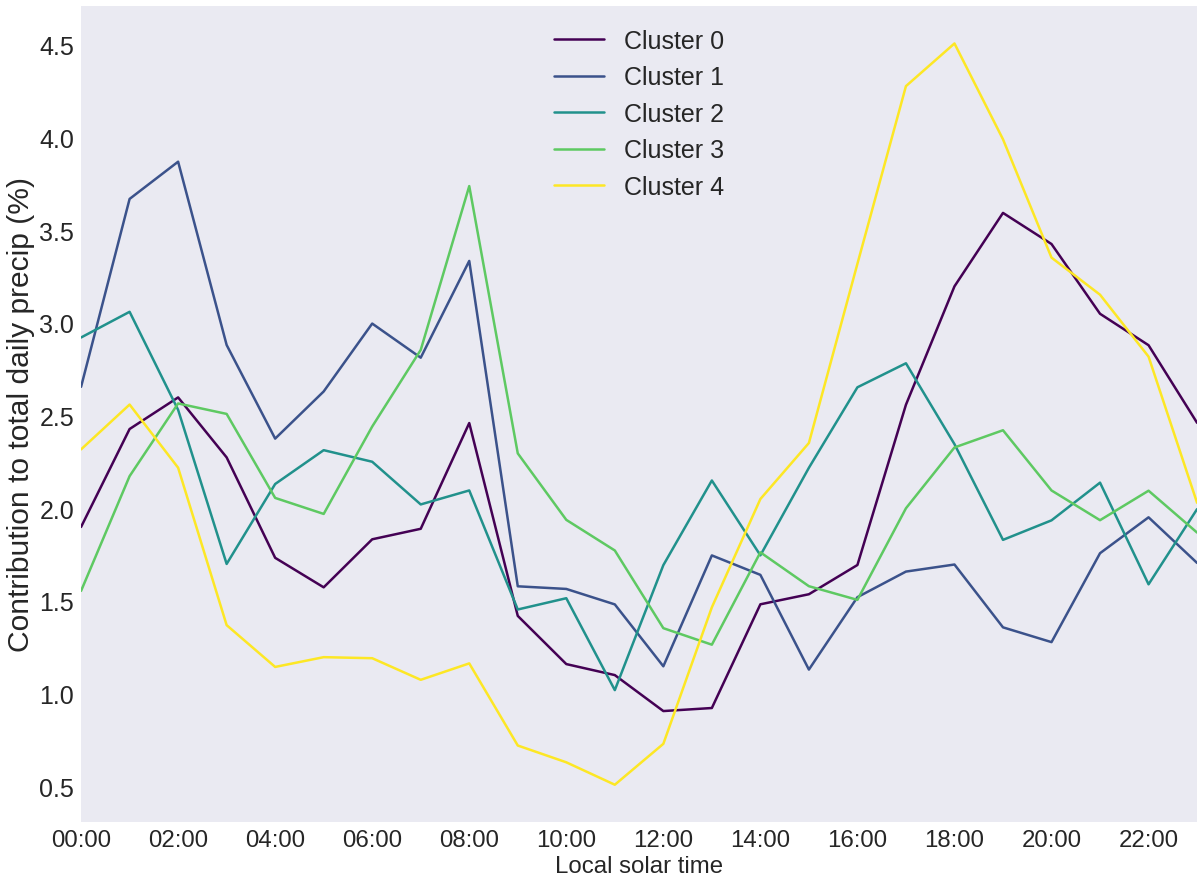

In [121]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 15))
plt.ylabel('Contribution to total daily precip (%)', fontsize= 30)
plt.grid()

n = 5
colors = plt.cm.viridis(np.linspace(0,1,n))

for i in range(n):
    localtime=np.array(())
    localtime=np.append(localtime, centers[i, 16:24])
    localtime=np.append(localtime, centers[i, 0:16])
    plt.plot(localtime, label = 'Cluster '+ str(i) , color=colors[i], linewidth= 2.5)

plt.xlim(0,23)
plt.xlabel('Local solar time', fontsize= 24 )
labels=['00:00','02:00','04:00','06:00','08:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00']
plt.xticks(np.linspace(0,22,12), labels,  fontsize=24)
         

plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})

plt.savefig('/media/juli/Elements/comparison/gpm_diurnal_cluster5.pdf')

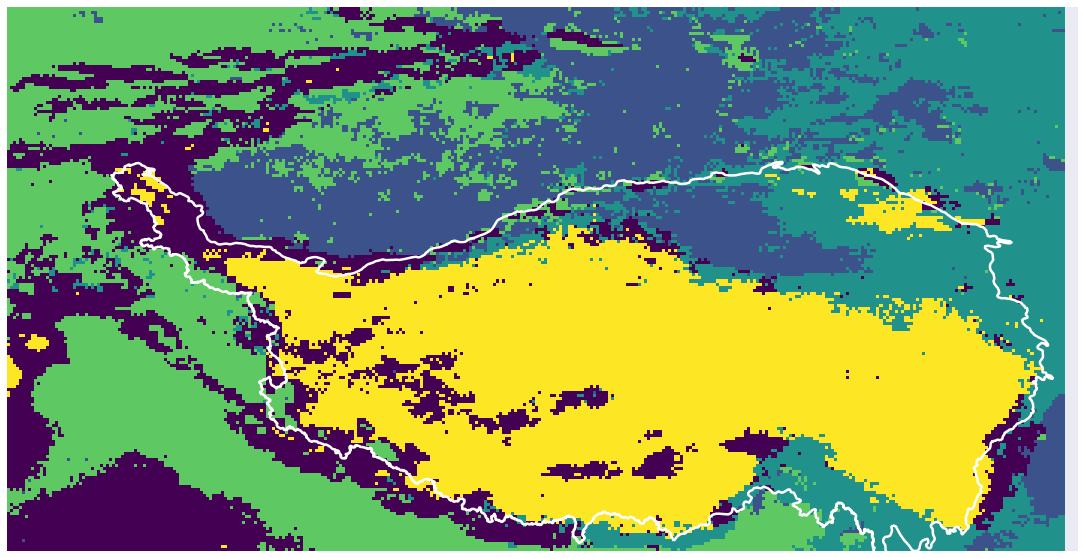

In [52]:
plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('viridis')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, cluster_grid.T, cmap = cmap) 


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='white', linewidth=2.5)

plt.savefig('/media/juli/Elements/comparison/cluster_diurnal_grid5.png')

## Getting optimal k (number of clusters) with elbow method

- mean distance of all data points to their centroid as a function of k 
- this will always decrease, but find elbow point

## Nr. of clusters for season

In [175]:
dis = np.array(())

for l in np.unique(labels):
    selected_rows = data[labels == l,:]
    for col in np.arange(0,12):
        m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
        dis = np.append(dis,m, axis = 0)

In [176]:
mean_distance = np.nanmean(dis)
mean_distance

2.3438313514551603

In [198]:
# test different k
k_variations = [1, 2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17]
distances = [] 

for k in k_variations:
    print('calculating... mean distances to centroid for K = ', k)
    kmeans = KMeans(n_clusters= k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_ 
    labels = kmeans.labels_
    dis = np.array(())

    for l in np.unique(labels):
        selected_rows = data[labels == l,:]
        for col in np.arange(0,12):
            m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
            dis = np.append(dis,m, axis = 0)
        mean = np.nanmean(dis)
    mean_distance = np.nanmean(mean)
    distances.append(mean_distance)

calculating... mean distances to centroid for K =  1
calculating... mean distances to centroid for K =  2
calculating... mean distances to centroid for K =  3
calculating... mean distances to centroid for K =  4
calculating... mean distances to centroid for K =  5
calculating... mean distances to centroid for K =  6
calculating... mean distances to centroid for K =  7
calculating... mean distances to centroid for K =  8
calculating... mean distances to centroid for K =  9
calculating... mean distances to centroid for K =  10
calculating... mean distances to centroid for K =  11
calculating... mean distances to centroid for K =  12
calculating... mean distances to centroid for K =  13
calculating... mean distances to centroid for K =  14
calculating... mean distances to centroid for K =  15
calculating... mean distances to centroid for K =  16
calculating... mean distances to centroid for K =  17


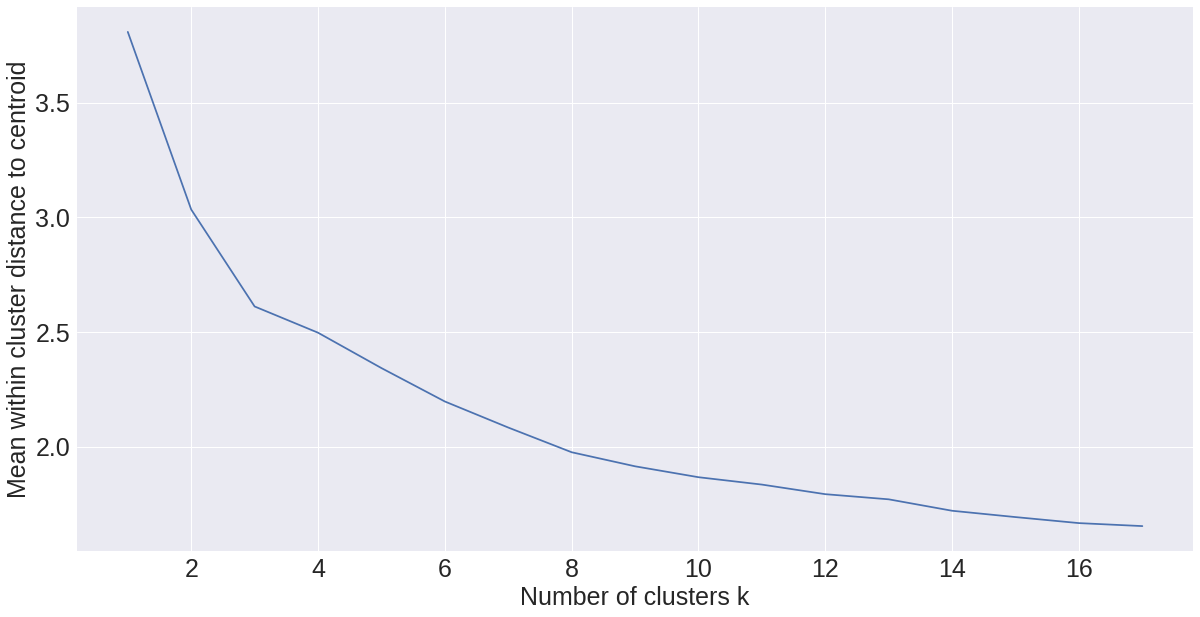

In [199]:
plt.figure(figsize=(20, 10))
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.plot(k_variations, distances)
plt.xlabel('Number of clusters k', fontsize = 25)
plt.ylabel('Mean within cluster distance to centroid', fontsize = 25)
plt.show()

## Nr. of clusters for diurnal curves

In [46]:
# test different k
k_variations = [1, 2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17]
distances = [] 

for k in k_variations:
    print('calculating... mean distances to centroid for K = ', k)
    kmeans = KMeans(n_clusters= k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_ 
    labels = kmeans.labels_
    dis = np.array(())

    for l in np.unique(labels):
        selected_rows = data[labels == l,:]
        for col in np.arange(0,12):
            m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
            dis = np.append(dis,m, axis = 0)
        mean = np.nanmean(dis)
    mean_distance = np.nanmean(mean)
    distances.append(mean_distance)

calculating... mean distances to centroid for K =  1
calculating... mean distances to centroid for K =  2
calculating... mean distances to centroid for K =  3
calculating... mean distances to centroid for K =  4
calculating... mean distances to centroid for K =  5
calculating... mean distances to centroid for K =  6
calculating... mean distances to centroid for K =  7
calculating... mean distances to centroid for K =  8
calculating... mean distances to centroid for K =  9
calculating... mean distances to centroid for K =  10
calculating... mean distances to centroid for K =  11
calculating... mean distances to centroid for K =  12
calculating... mean distances to centroid for K =  13
calculating... mean distances to centroid for K =  14
calculating... mean distances to centroid for K =  15
calculating... mean distances to centroid for K =  16
calculating... mean distances to centroid for K =  17


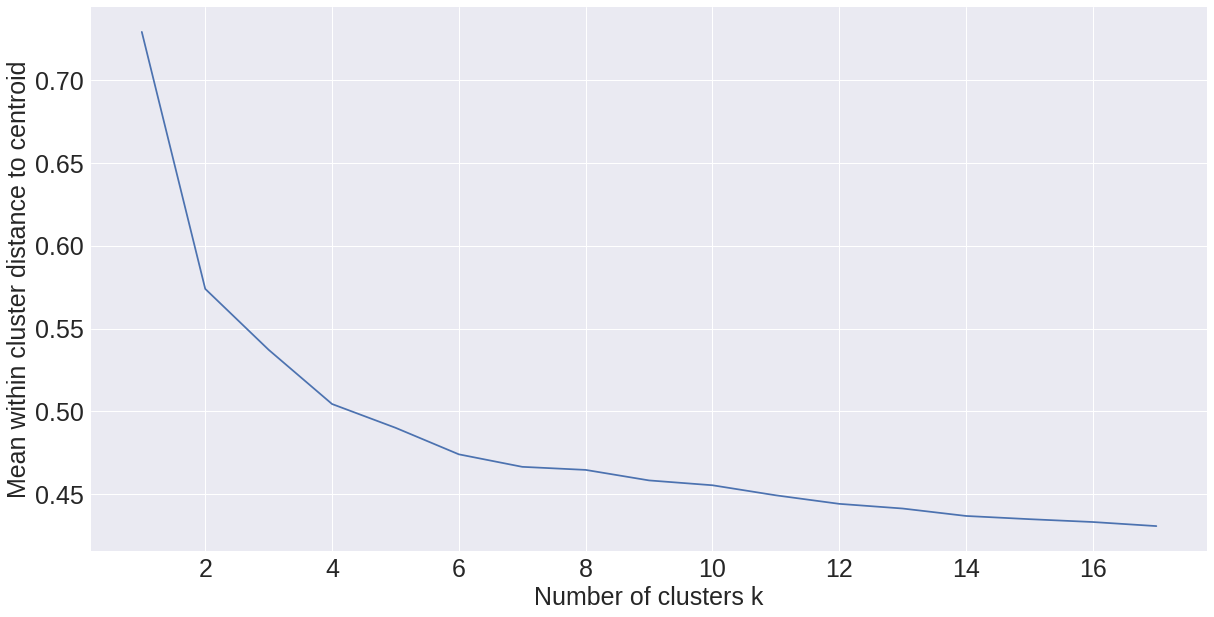

In [47]:
plt.figure(figsize=(20, 10))
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.plot(k_variations, distances)
plt.xlabel('Number of clusters k', fontsize = 25)
plt.ylabel('Mean within cluster distance to centroid', fontsize = 25)
plt.show()

# PCA of seasonal precip over the TP 

In [10]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_seasonal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [11]:
from sklearn.decomposition import PCA

#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (12,351*181))
data= data.transpose()
np.shape(data)
data

array([[ 0.79384077,  0.21038234,  1.33072245, ...,  0.13289794,
         0.11021849,  0.57224262],
       [ 0.77806216,  0.26074788,  1.89385414, ...,  0.08126032,
         0.17184958,  0.59550965],
       [ 0.78979546,  0.23071705,  2.05688357, ...,  0.11541067,
         0.17574455,  0.53062469],
       ..., 
       [ 0.        ,  0.47892457,  2.43920159, ...,  5.05111742,
         2.02956891,  0.        ],
       [ 0.        ,  0.26290721,  1.4889611 , ...,  4.66566086,
         2.05562139,  0.02769067],
       [ 0.        ,  0.03552624,  1.73283184, ...,  4.234447  ,
         1.27894461,  0.0666117 ]], dtype=float32)

In [36]:
pca = PCA()
pca.fit(data)
comps= pca.components_
np.shape(comps)


(12, 12)

In [51]:
pca = PCA(n_components = 2)
new = pca.fit_transform(data)  
np.shape(new[:,0])
# reshape data space back to grid 
pca1= np.reshape(new[:,0], ((351,181)))
pca2= np.reshape(new[:,1], ((351,181)))

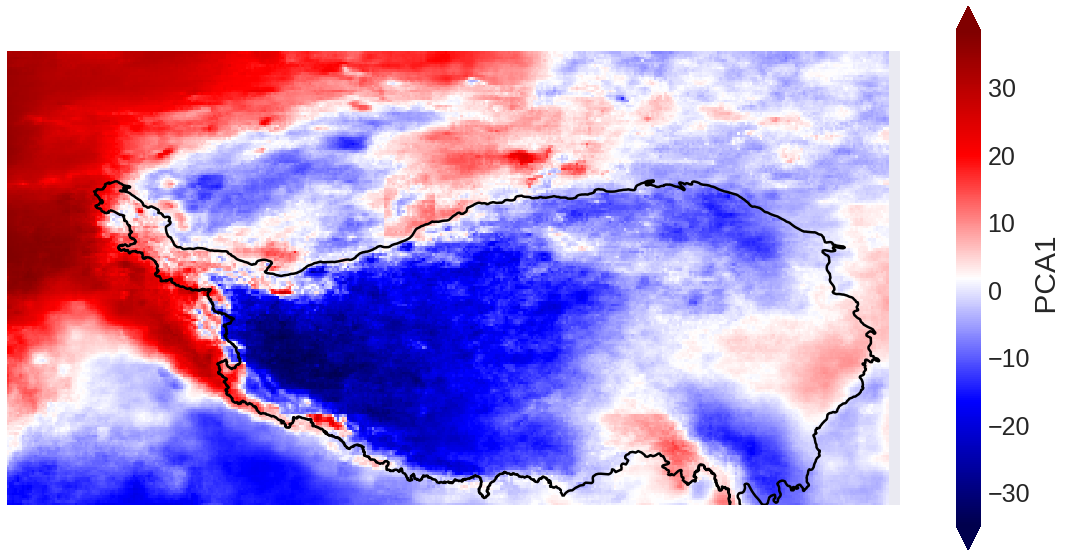

In [277]:
plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('seismic')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, pca_1.T, cmap = cmap) 


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)

cbar = plt.colorbar(extend= 'both')
cbar.set_label(' PCA1', fontsize= 30)


plt.savefig('/media/juli/Elements/comparison/pca1.png')

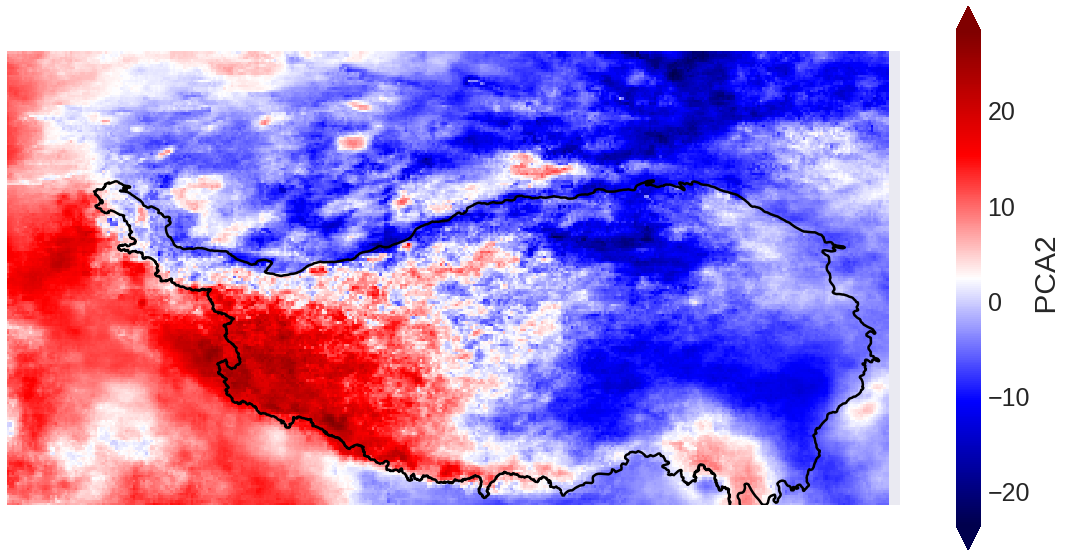

In [276]:
pca2= np.reshape(new[:,1], ((351,181)))
plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('seismic')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, pca2.T, cmap = cmap) 

cbar = plt.colorbar(extend= 'both')
cbar.set_label(' PCA2', fontsize= 30
              )


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=2.5)

plt.savefig('/media/juli/Elements/comparison/pca2.png')

In [106]:
# attributes of PC instance 
comps= pca.components_ # direction of max variance, sorted by explained variance, shape = n components x n features 
var= pca.explained_variance_ratio_ # how much of the variance (%)is explained by each component (shape = n components)
pca.singular_values_ # shape = n_components 
means = pca.mean_ # shape = n_features 


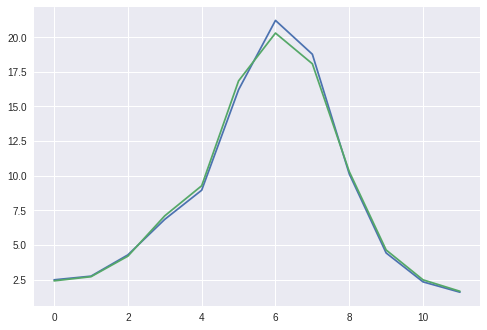

In [71]:
plt.plot(comps[1]+means)
plt.plot(comps[0]+means)
#plt.plot(comps[0])
#plt.plot(comps[1])
plt.show()

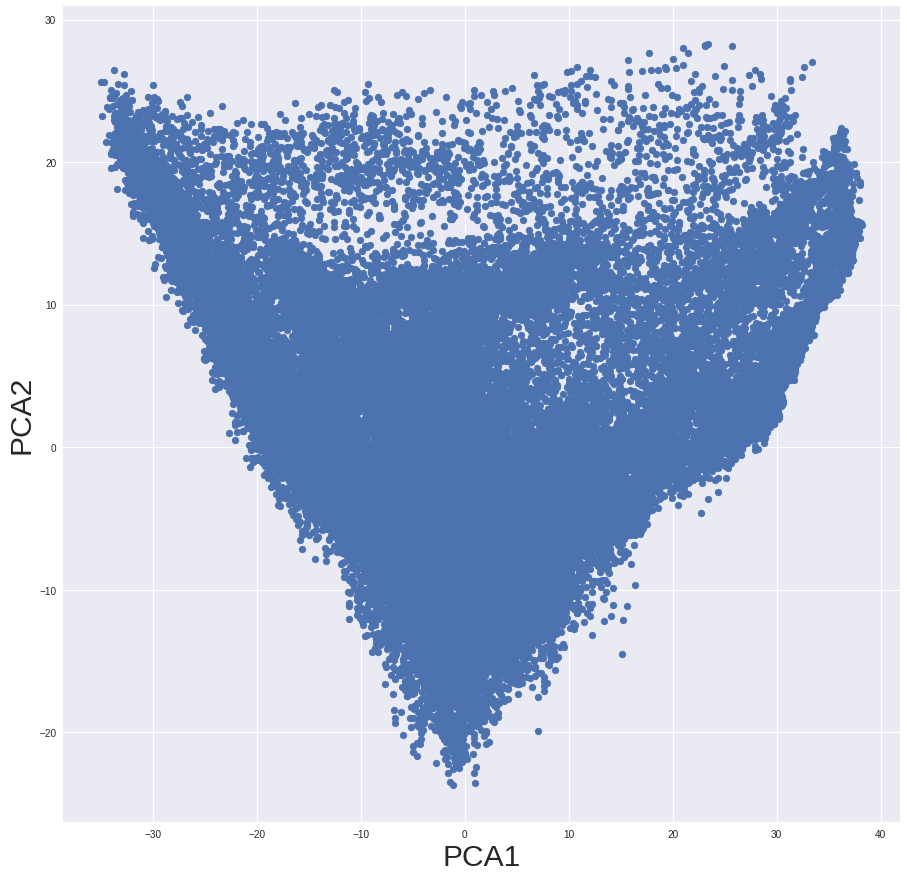

In [58]:
plt.figure(figsize = ((15,15)))

pca1= pca1.flatten()
pca2= pca2.flatten()
plt.scatter(pca1, pca2 )
plt.xlabel('PCA1', fontsize= '30')
plt.ylabel('PCA2', fontsize= '30')
plt.show()

In [244]:
cov = pca.get_covariance()


(12, 12)

 - domain dependency  is rather a problem from time series analysis 
 - eigenvectors* PC + mean to obtain actual values 
 - PC curve shows deviation from mean curve 
 - PCA heatmap, plot PCA1 and PCA2 against each other and their frequencies in order to see whether you can find any clusters 
 - why are the vectors for PCA1 and PCA2 so similar? does this reinforce the dipole mode and that only the dry and wet season can explain the seasonality? or do I have to multiply means + components with sth? 
 

## PCA diurnal

In [4]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_diurnal.nc4'
precip, lon, lat = read_in_netcdf(file)


In [5]:
precip= precip*100 

In [6]:
# calculate hourly instead of 30 min 
precip_avg= np.zeros((351,181))
i=0 
for idx, row in enumerate(precip[:,:]):
    if (i % 2) == 0:
        a = np.nansum([row, precip[:,:][idx]], axis = 0)
        #print(idx, np.shape(a))
        precip_avg= np.concatenate((precip_avg, a),axis =0)
    i+=1


In [7]:
new = np.reshape(precip_avg,(25,351,181))
precip = new[1::,:,:]
np.shape(precip)

(24, 351, 181)

In [8]:
np.sum(precip[:,1,1])

104.40866839885712

In [9]:

#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (24,351*181))
data= data.transpose()
np.shape(data)
data

array([[3.46317625, 1.20641434, 0.32187253, ..., 2.04255271, 2.39563441,
        1.92686915],
       [2.55462384, 2.68691373, 0.48765746, ..., 1.00291872, 3.17110085,
        5.17100906],
       [4.51381779, 1.66119063, 0.63981086, ..., 1.46901512, 1.68823707,
        4.98059034],
       ...,
       [3.81819987, 2.00407791, 2.76321006, ..., 4.88978863, 6.29541206,
        4.60281944],
       [3.06068516, 2.68843627, 4.51290464, ..., 5.78473425, 7.20388985,
        3.20985699],
       [4.94787264, 3.78016019, 2.56567979, ..., 4.5072608 , 7.00561333,
        3.47599769]])

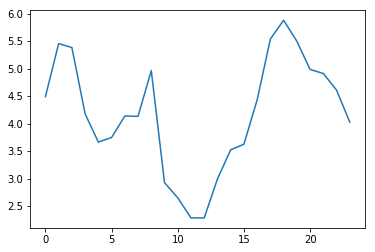

In [11]:
mean = np.nanmean(precip, axis=(1, 2))
localtime=np.array(())
localtime=np.append(localtime, mean[16:24])
localtime=np.append(localtime, mean[0:16])
plt.plot(localtime)
plt.show()


In [223]:
#pca = PCA()
#pca.fit(data)
#comps= pca.components_
#np.shape(comps)


pca = PCA(n_components = 2)
new = pca.fit_transform(data)  
np.shape(new[:,0])
# reshape data space back to grid 
pca1= np.reshape(new[:,0], ((351,181)))
pca2= np.reshape(new[:,1], ((351,181)))

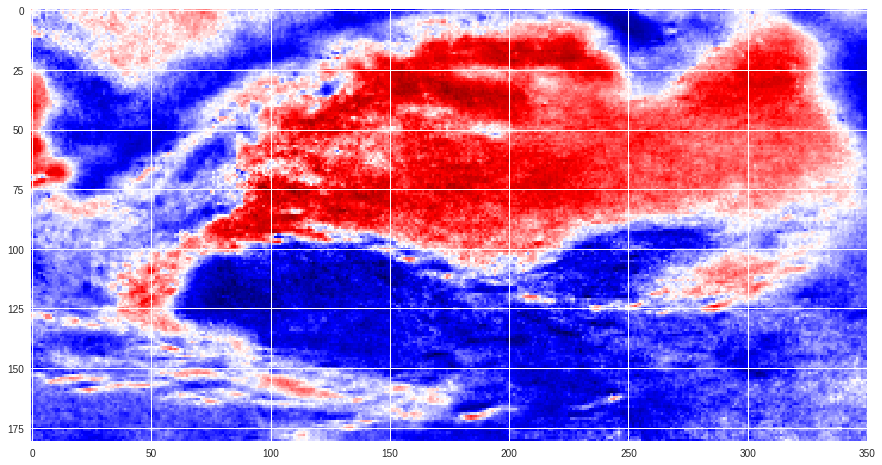

In [224]:
# grid plot
plt.figure(figsize= (15,20))
cmap = plt.cm.get_cmap('seismic')
plt.imshow(pca1.T, cmap = cmap)
plt.show()

In [225]:
# attributes of instance 
comps= pca.components_ # direction of max variance, sorted by explained variance, shape = n components x n features 
var= pca.explained_variance_ratio_ # how much of the variance (%)is explained by each component (shape = n components)
pca.singular_values_ # shape = n_components 
means = pca.mean_ # shape = n_features 


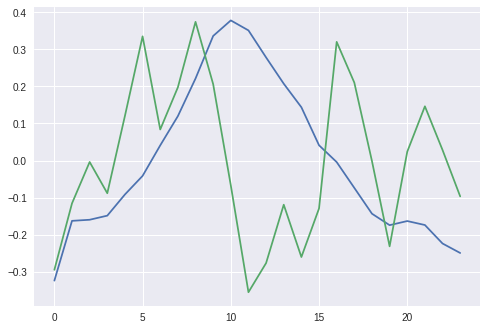

In [231]:
# plot components 

comp1=np.array(())
comp1=np.append(comp1, comps[0, 32:48])
comp1=np.append(comp1, comps[0, 0:32])


comp2=np.array(())
comp2=np.append(comp2, comps[1, 32:48])
comp2=np.append(comp2, comps[1, 0:32])


plt.plot(comp1)
plt.plot(comp2)



#plt.plot(comp1+localtime)
#plt.plot(comp2+localtime)
plt.show()

In [19]:
#import eofs # another package, library for meteorological data

- solve package inconsistencies